In [1]:
pip install requests


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
pip install folium

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
API_KEY = ""

In [4]:
import requests
import folium
import polyline

routes = [
    # Barat
    ("-6.1708329,106.8221650", "-6.179989098542812,106.82322450992254", "Barat-1", "red"),
    ("-6.181859453950514,106.82278603346968", "-6.170498968942276,106.8213434702709", "Barat-2", "darkred"),
    
    # Selatan
    ("-6.179772920487191,106.82291252358272", "-6.178322275737021,106.83177454177398", "Selatan-1", "blue"),
    ("-6.180660393690087,106.83235359703912", "-6.180306987173679,106.82231670810442", "Selatan-2", "darkblue"),
    
    # Timur
    ("-6.18019319785607,106.83082914672183", "-6.171942688627777,106.83096435934321", "Timur-1", "green"),
    ("-6.174778111021088,106.83269919775273", "-6.180135879382528,106.83235941830395", "Timur-2", "darkgreen"),
    
    # Utara
    ("-6.173481868525716, 106.83015480251592", "-6.17119576054158, 106.82313005955892", "Utara-1", "purple"),
    ("-6.17018232807361, 106.82559543616475", "-6.172460584391077, 106.83048668013593", "Utara-2", "darkpurple"),
]

# Peta Monas
m = folium.Map(location=[-6.1754, 106.8272], zoom_start=16)

for origin, destination, name, color in routes:
    url = (
        f"https://maps.googleapis.com/maps/api/directions/json?"
        f"origin={origin}&destination={destination}&departure_time=now&key={API_KEY}"
    )
    response = requests.get(url).json()
    
    if response["status"] == "OK":
        # Decode polyline jadi koordinat
        route_polyline = response["routes"][0]["overview_polyline"]["points"]
        route_coords = polyline.decode(route_polyline)
        
        # Gambar garis rute
        folium.PolyLine(
            route_coords, color=color, weight=4, opacity=0.8, popup=name
        ).add_to(m)
        
        # Marker origin
        folium.Marker(
            route_coords[0], popup=f"Start {name}", icon=folium.Icon(color="orange")
        ).add_to(m)
        
        # Marker destination
        folium.Marker(
            route_coords[-1], popup=f"End {name}", icon=folium.Icon(color="blue")
        ).add_to(m)
    else:
        print(f"❌ Gagal ambil rute {name}: {response['status']}")

m.save("monas_routes.html")
print("✅ Semua rute + marker tersimpan di monas_routes.html")


✅ Semua rute + marker tersimpan di monas_routes.html


In [6]:
import requests
import csv
import time
from datetime import datetime, timedelta

# Daftar rute (2 per sisi)
routes = [
    # Barat
    ("-6.1708329,106.8221650", "-6.179989098542812,106.82322450992254", "West"),
    ("-6.181859453950514,106.82278603346968", "-6.170498968942276,106.8213434702709", "West"),
    
    # Selatan
    ("-6.179772920487191,106.82291252358272", "-6.178322275737021,106.83177454177398", "South"),
    ("-6.180660393690087,106.83235359703912", "-6.180306987173679,106.82231670810442", "South"),
    
    # Timur
    ("-6.18019319785607,106.83082914672183", "-6.171942688627777,106.83096435934321", "East"),
    ("-6.174778111021088,106.83269919775273", "-6.180135879382528,106.83235941830395", "East"),
    
    # Utara
    ("-6.173481868525716,106.83015480251592", "-6.17119576054158,106.82313005955892", "North"),
    ("-6.17018232807361,106.82559543616475", "-6.172460584391077,106.83048668013593", "North"),
]

# Nama file CSV
csv_file = "monas_traffic.csv"

# Buat header csv 
with open(csv_file, "a", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    if f.tell() == 0:  # file kosong
        writer.writerow([
            "timestamp", "road", "distance_meters",
            "duration_free_sec", "duration_traffic_sec", "volume_index"
        ])

print("🚦 Mulai logging data traffic Monas...")
print(f"Hasil akan tersimpan di: {csv_file}")

# Waktu mulai & selesai
start_time = datetime.strptime("05:00", "%H:%M").replace(
    year=datetime.now().year, month=datetime.now().month, day=datetime.now().day
)
end_time = datetime.strptime("08:00", "%H:%M").replace(
    year=datetime.now().year, month=datetime.now().month, day=datetime.now().day
)


while datetime.now() < start_time:
    time.sleep(30)

while datetime.now() <= end_time:
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    records = []

    for origin, destination, road in routes:
        url = (
            f"https://maps.googleapis.com/maps/api/directions/json"
            f"?origin={origin}&destination={destination}"
            f"&departure_time=now&key={API_KEY}"
        )
        response = requests.get(url).json()

        if response["status"] == "OK":
            leg = response["routes"][0]["legs"][0]
            distance = leg["distance"]["value"]
            duration_free = leg["duration"]["value"]
            duration_traffic = leg.get("duration_in_traffic", {}).get("value", duration_free)
            volume_index = round(duration_traffic / duration_free, 2)

            records.append([timestamp, road, distance, duration_free, duration_traffic, volume_index])
        else:
            print(f"❌ Gagal ambil rute {road}: {response['status']}")

    # Simpan ke CSV
    with open(csv_file, "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerows(records)

    print(f"✅ {timestamp} - {len(records)} data ditambahkan ke CSV")

    # Tunggu 5 menit
    time.sleep(300)


🚦 Mulai logging data traffic Monas...
Hasil akan tersimpan di: monas_traffic.csv
✅ 2025-09-11 07:39:21 - 8 data ditambahkan ke CSV
✅ 2025-09-11 07:44:27 - 8 data ditambahkan ke CSV
✅ 2025-09-11 07:49:34 - 8 data ditambahkan ke CSV
✅ 2025-09-11 07:54:43 - 8 data ditambahkan ke CSV
✅ 2025-09-11 07:59:49 - 8 data ditambahkan ke CSV


In [9]:
pip install plotly

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB 991.0 kB/s eta 0:00:10
    --------------------------------------- 0.1/9.8 MB 1.7 MB/s eta 0:00:06
    --------------------------------------- 0.1/9.8 MB 1.7 MB/s eta 0:00:06
    --------------------------------------- 0.2/9.8 MB 1.1 MB/s eta 0:00:09
    --------------------------------------- 0.2/9.8 MB 1.1 MB/s eta 0:00:09
   - -------------------------------------- 0.3/9.8 MB 1.1 MB/s eta 0:00:09
   - -------------------------------------- 0.4/9.8 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.4/9.8 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.4/9.8 MB 1.0 MB/s eta 0:00:10
   -- ------------------------------------- 0.5/9.8 MB 1.2 MB/s eta 0:00:08
   -- ------------------------------------- 0.7/9.8 MB 1.3 MB/s eta 0:00:07
   --- ------------------------------------ 0.9/9.8 MB 1.6 MB/s eta 0:00:06
   ---- ---------


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


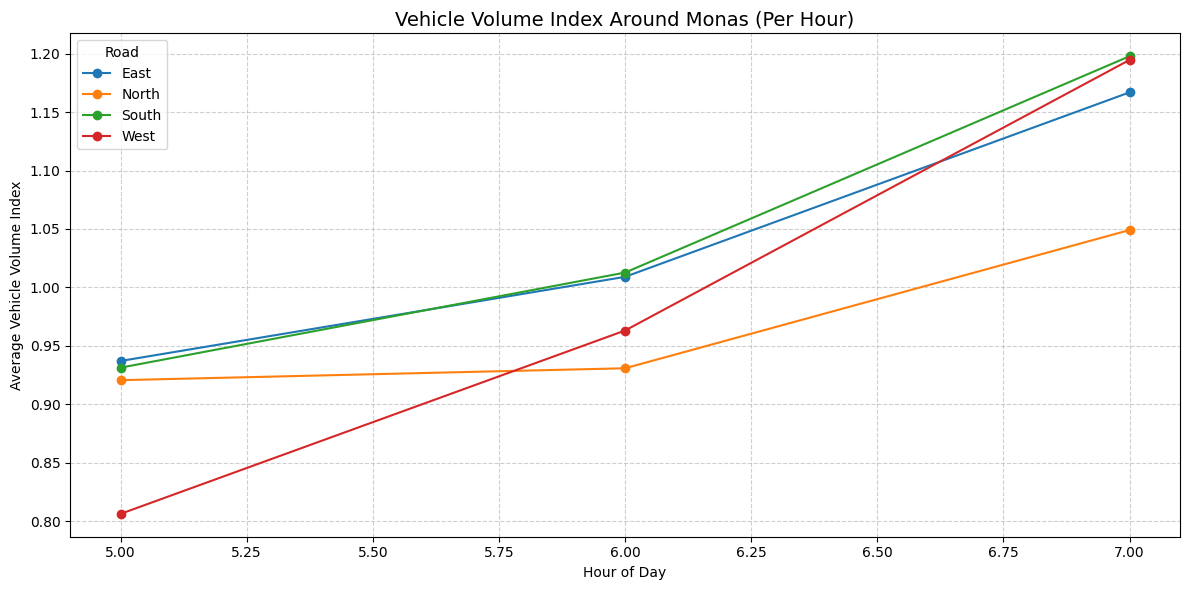

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# === Load dataset ===
df = pd.read_csv("monas_traffic.csv")

# Convert timestamp ke datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

# === Static Visualization (Matplotlib) ===
volume_by_time = df.groupby(['hour', 'road'])['volume_index'].mean().reset_index()

plt.figure(figsize=(12, 6))
for road in volume_by_time['road'].unique():
    subset = volume_by_time[volume_by_time['road'] == road]
    plt.plot(subset['hour'], subset['volume_index'], marker='o', label=road)

plt.title("Vehicle Volume Index Around Monas (Per Hour)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicle Volume Index")
plt.legend(title="Road")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("monas_vehicle_volume.png")   # save file
plt.show()


# === Interactive Visualization (Plotly) ===
fig = px.line(
    volume_by_time,
    x="hour",
    y="volume_index",
    color="road",
    markers=True,
    title="Interactive Vehicle Volume Index Around Monas (Per Hour)"
)

# Simpan ke file HTML (bisa dibuka di browser)
fig.write_html("monas_vehicle_volume_interactive.html")
# fig.show()


In [12]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 435.7 kB/s eta 0:00:01
   ------------- ------------------------ 102.4/294.9 kB 845.5 kB/s eta 0:00:01
   ------------------------------ ------- 235.5/294.9 kB 962.7 kB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- 294.9/294.9 kB 958.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


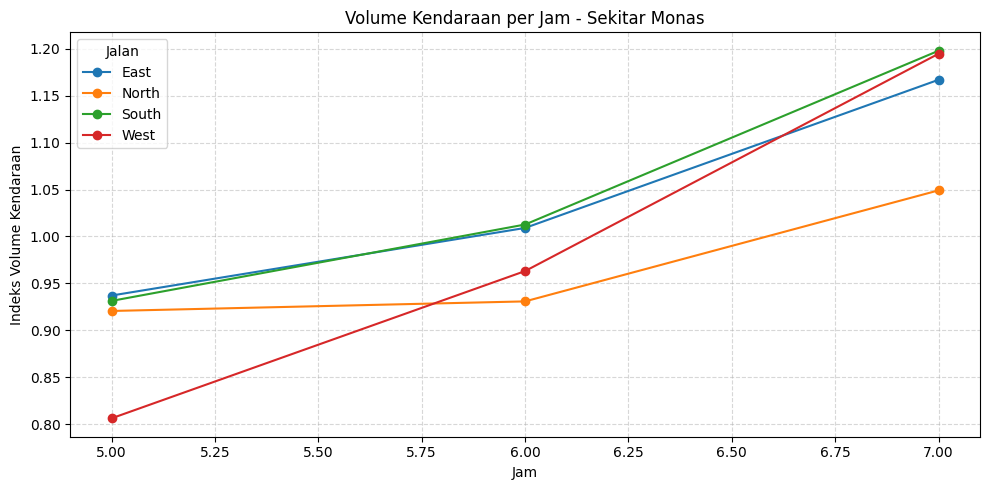

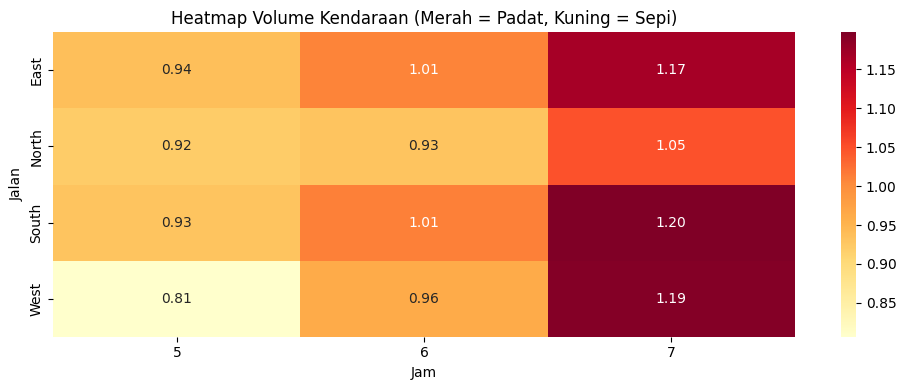

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load data ===
df = pd.read_csv("monas_traffic.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

# Hitung rata-rata volume per jam per jalan
volume_by_time = df.groupby(['hour', 'road'])['volume_index'].mean().reset_index()


plt.figure(figsize=(10,5))
for road in volume_by_time['road'].unique():
    subset = volume_by_time[volume_by_time['road'] == road]
    plt.plot(subset['hour'], subset['volume_index'], marker='o', label=road)

plt.title("Volume Kendaraan per Jam - Sekitar Monas")
plt.xlabel("Jam")
plt.ylabel("Indeks Volume Kendaraan")
plt.legend(title="Jalan")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("volume_line.png")
plt.show()


pivot = volume_by_time.pivot(index="road", columns="hour", values="volume_index")

plt.figure(figsize=(10,4))
sns.heatmap(pivot, cmap="YlOrRd", annot=True, fmt=".2f")
plt.title("Heatmap Volume Kendaraan (Merah = Padat, Kuning = Sepi)")
plt.xlabel("Jam")
plt.ylabel("Jalan")
plt.tight_layout()
plt.savefig("volume_heatmap.png")
plt.show()
